# Preliminary analysis of mainnet transaction validation times

## Setup

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

### Generate data

We use the `db-analyser` tool:

```bash
nix build 'github:IntersectMBO/ouroboros-consensus/release-ouroboros-consensus-diffusion-0.20.0.0#db-analyser'
```

Measure CPU usage starting from [Epoch 350](https://cardanoscan.io/block/7477993) and doing full application of blocks.

```bash
db-analyser \
  --verbose \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-apply-65836843.csv \
  cardano --config node.json
```

Re-measure CPU usage but only reapplying blocks.

```bash
db-analyser \
  --verbose \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-reapply-65836843.csv \
    --reapply \
  cardano --config node.json
```

The dominant difference between application and reapplication is the verification of transaction signatures and the execution of Plutus scripts.

## Read data

### Application

In [2]:
timingsApply <- fread("ledger-ops-apply-65836843.csv.gz")[
    `slot` >= 65836843, # Epoch 350
    .(
        `Slot`=`slot`,
        `Block [kB]`=`blockBytes`/1000,
        `Tx count`=as.numeric(`txs`),
        `Tx size [kB]`=txs_size/1000,
        `Tx exec [step]`=as.numeric(`txs_steps`),
        `Apply CPU [ms]`=`totalTime`/1000
    )
]
timingsApply %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836984   Min.   : 0.864   Min.   :  0.00   Min.   : 0.000  
 1st Qu.: 89833176   1st Qu.: 6.235   1st Qu.:  4.00   1st Qu.: 5.369  
 Median :113740091   Median :20.825   Median : 10.00   Median :19.962  
 Mean   :113666120   Mean   :31.091   Mean   : 14.19   Mean   :30.231  
 3rd Qu.:137528206   3rd Qu.:50.030   3rd Qu.: 21.00   3rd Qu.:49.175  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]     
 Min.   :0.000e+00   Min.   :    0.256  
 1st Qu.:4.381e+08   1st Qu.:    2.487  
 Median :2.024e+09   Median :    6.914  
 Mean   :3.272e+09   Mean   :   11.393  
 3rd Qu.:5.067e+09   3rd Qu.:   15.266  
 Max.   :3.625e+10   Max.   :29762.078  

### Reapplication

In [3]:
timingsReapply <- fread("ledger-ops-reapply-65836843.csv.gz")[
    `slot` >= 65836843, # Epoch 350
    .(
        `Slot`=`slot`,
        `Reapply CPU [ms]`=`totalTime`/1000
    )
]
timingsReapply %>% summary

      Slot           Reapply CPU [ms]  
 Min.   : 65836984   Min.   :    0.05  
 1st Qu.: 89833176   1st Qu.:    0.52  
 Median :113740091   Median :    1.04  
 Mean   :113666120   Mean   :    1.81  
 3rd Qu.:137528206   3rd Qu.:    2.02  
 Max.   :161151612   Max.   :31798.99  

### Join the datasets

In [4]:
timings <- timingsApply[timingsReapply, on="Slot"]
timings[, `Apply - Reapply CPU [ms]`:=`Apply CPU [ms]`-`Reapply CPU [ms]`]
timings %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836984   Min.   : 0.864   Min.   :  0.00   Min.   : 0.000  
 1st Qu.: 89833176   1st Qu.: 6.235   1st Qu.:  4.00   1st Qu.: 5.369  
 Median :113740091   Median :20.825   Median : 10.00   Median :19.962  
 Mean   :113666120   Mean   :31.091   Mean   : 14.19   Mean   :30.231  
 3rd Qu.:137528206   3rd Qu.:50.030   3rd Qu.: 21.00   3rd Qu.:49.175  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]      Reapply CPU [ms]  
 Min.   :0.000e+00   Min.   :    0.256   Min.   :    0.05  
 1st Qu.:4.381e+08   1st Qu.:    2.487   1st Qu.:    0.52  
 Median :2.024e+09   Median :    6.914   Median :    1.04  
 Mean   :3.272e+09   Mean   :   11.393   Mean   :    1.81  
 3rd Qu.:5.067e+09   3rd Qu.:   15.266   3rd Qu.:    2.02  
 Max.   :3.625e+10   Max.   :29762.078   Max.   :31798.99  
 Apply - Reapply CPU [ms]
 Min.   :-12198.644      
 1st Qu.:     1.829     

### Cleanup

A few blocks have anomalously large times.

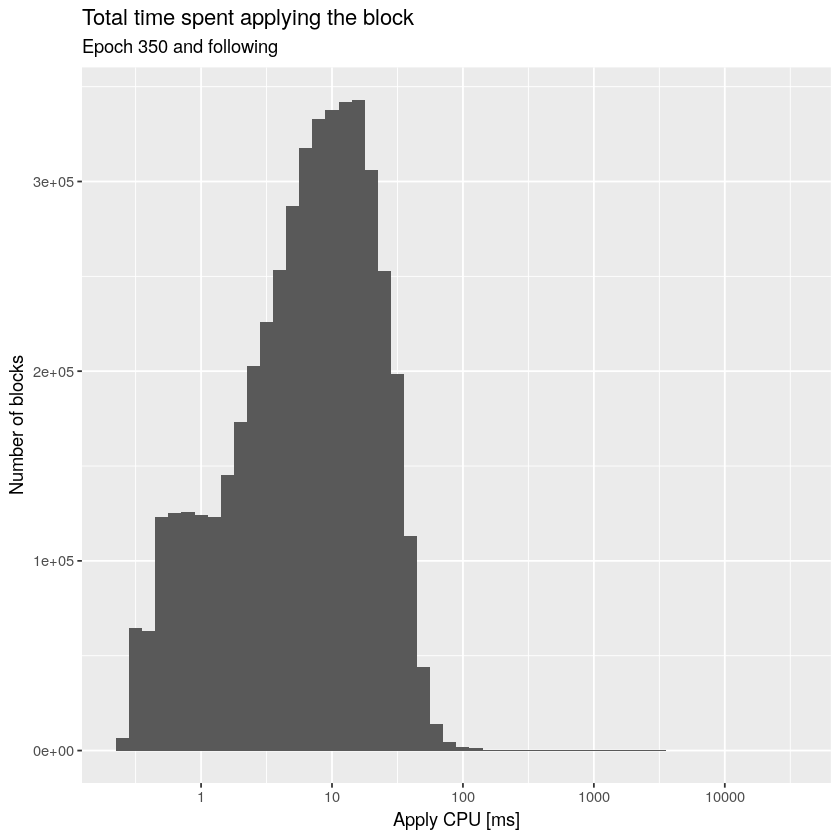

In [5]:
ggplot(timings, aes(x=`Apply CPU [ms]`)) +
    geom_histogram(binwidth=0.1) +
    scale_x_log10() +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block",
        "Epoch 350 and following"
    )

Ignore blocks that exceed the 99.9 %tile in CPU time because presumably there is something anomalous about these.

In [6]:
timeLimit <- timings[`Tx count` > 0, quantile(`Apply CPU [ms]`, 0.95)]
timeLimit

95% 
33.72

## Basic statistics

In [7]:
basics <- timings[
    `Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`,
    .(
        `Apply CPU [ms/tx]`=`Apply CPU [ms]`/`Tx count`,
        `Reapply CPU [ms/tx]`=`Reapply CPU [ms]`/`Tx count`,
        `Delta CPU [ms/tx]`=(`Apply CPU [ms]`-`Reapply CPU [ms]`)/`Tx count`,
        `Apply CPU [ms/kB]`=`Apply CPU [ms]`/`Tx size [kB]`,
        `Reapply CPU [ms/kB]`=`Reapply CPU [ms]`/`Tx size [kB]`,
        `Delta CPU [ms/kB]`=(`Apply - Reapply CPU [ms]`)/`Tx size [kB]`
    ),
    .(
        `Slot`
    )
]
basics %>% summary

      Slot           Apply CPU [ms/tx]  Reapply CPU [ms/tx] Delta CPU [ms/tx]
 Min.   : 65836998   Min.   : 0.08677   Min.   : 0.02699    Min.   : 0.0000  
 1st Qu.: 88673166   1st Qu.: 0.45171   1st Qu.: 0.07700    1st Qu.: 0.3326  
 Median :114497069   Median : 0.65486   Median : 0.10275    Median : 0.5285  
 Mean   :113601912   Mean   : 0.81517   Mean   : 0.13555    Mean   : 0.6796  
 3rd Qu.:137709531   3rd Qu.: 0.97539   3rd Qu.: 0.14975    3rd Qu.: 0.8372  
 Max.   :161151612   Max.   :32.93500   Max.   :13.79300    Max.   :31.9810  
 Apply CPU [ms/kB]  Reapply CPU [ms/kB] Delta CPU [ms/kB]
 Min.   : 0.01433   Min.   :0.003066    Min.   : 0.0000  
 1st Qu.: 0.25023   1st Qu.:0.034772    1st Qu.: 0.1956  
 Median : 0.35583   Median :0.057900    Median : 0.2894  
 Mean   : 0.49997   Mean   :0.107658    Mean   : 0.3923  
 3rd Qu.: 0.54710   3rd Qu.:0.108966    3rd Qu.: 0.4387  
 Max.   :25.11111   Max.   :8.358025    Max.   :24.5556  

### CPU time per transaction

In [8]:
melted <- melt(
    basics[, .(`Slot`, `Apply`=`Apply CPU [ms/tx]`, `Reapply`=`Reapply CPU [ms/tx]`, `Apply - Reapply`=`Delta CPU [ms/tx]`)],
    id.vars="Slot",
    measure.vars=c("Apply", "Reapply", "Apply - Reapply"),
    variable.name="Metric",
    value.name="CPU [ms/tx]"
)

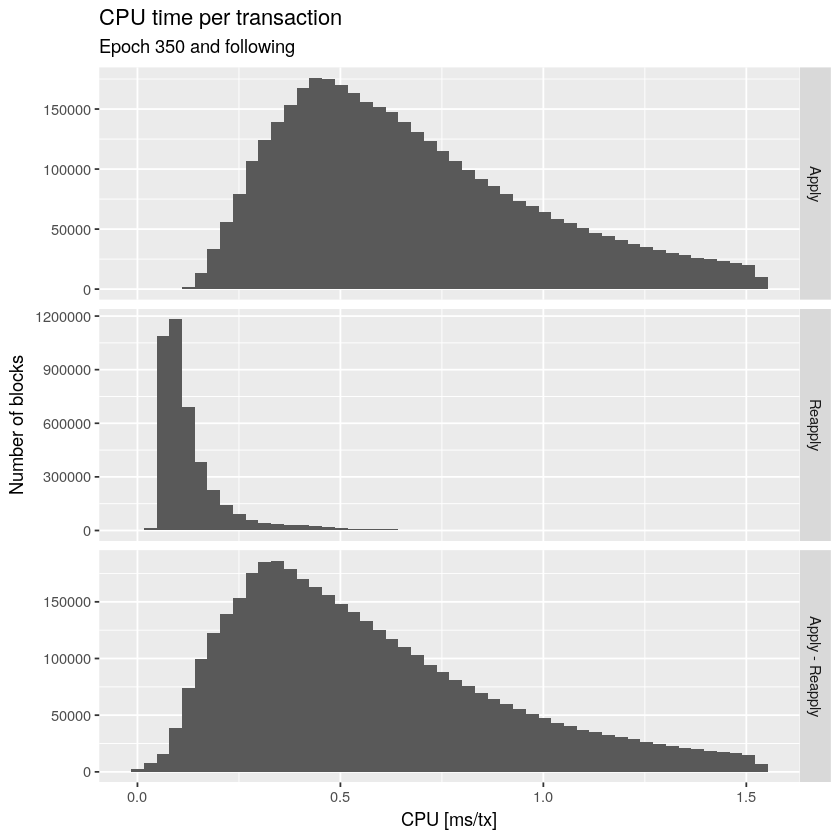

In [9]:
ggplot(melted[`CPU [ms/tx]` > 0 & `CPU [ms/tx]` < melted[, quantile(`CPU [ms/tx]`, 0.95)]], aes(x=`CPU [ms/tx]`)) +
    geom_histogram(bins=50) +
    ylab("Number of blocks") +
    facet_grid(`Metric` ~ ., scales="free_y") +
    ggtitle(
        "CPU time per transaction",
        "Epoch 350 and following"
    )

In [10]:
ggsave("cpu-per-tx.png", units="in", dpi=150, width=16, height=8)

In [11]:
melted[, .(`Median CPU [ms/tx]`=median(`CPU [ms/tx]`)), .(`Metric`)]

Metric,Median CPU [ms/tx]
<fct>,<dbl>
Apply,0.6548571
Reapply,0.1027500
Apply - Reapply,0.5285000


### CPU time per byte of transaction

In [12]:
melted <- melt(
    basics[, .(`Slot`, `Apply`=`Apply CPU [ms/kB]`, `Reapply`=`Reapply CPU [ms/kB]`, `Apply - Reapply`=`Delta CPU [ms/kB]`)],
    id.vars="Slot",
    measure.vars=c("Apply", "Reapply", "Apply - Reapply"),
    variable.name="Metric",
    value.name="CPU [ms/kB]"
)

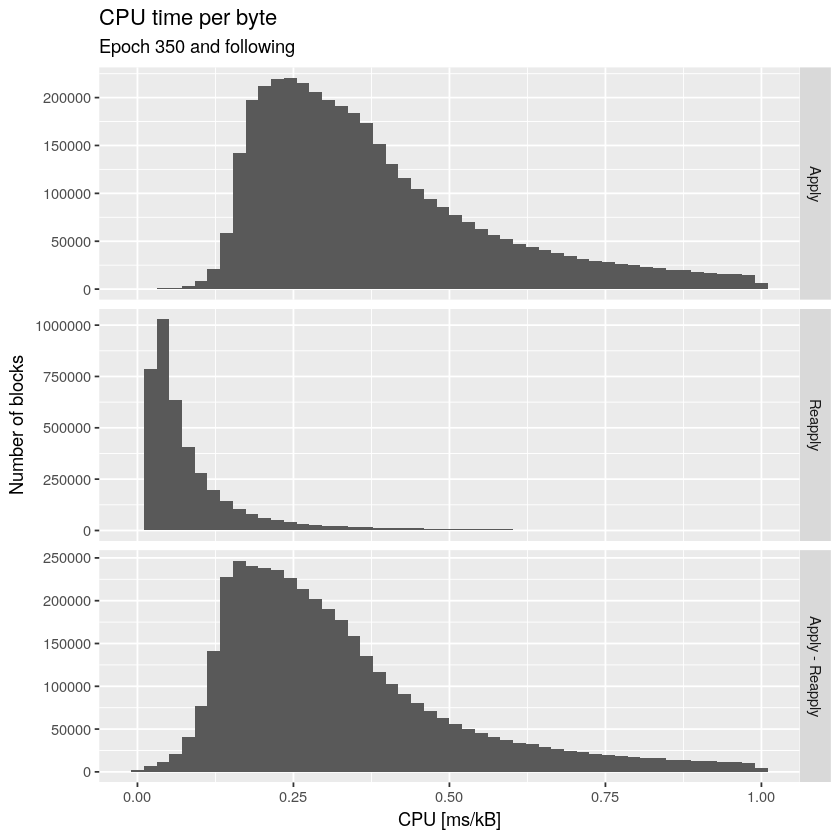

In [13]:
ggplot(melted[`CPU [ms/kB]` > 0 & `CPU [ms/kB]` < melted[, quantile(`CPU [ms/kB]`, 0.95)]], aes(x=`CPU [ms/kB]`)) +
    geom_histogram(bins=50) +
    ylab("Number of blocks") + 
    facet_grid(`Metric` ~ ., scales="free_y") +
    ggtitle(
        "CPU time per byte",
        "Epoch 350 and following"
    )

In [14]:
ggsave("cpu-per-kb.png", units="in", dpi=150, width=16, height=8)

In [15]:
melted[, .(`Median CPU [ms/kB]`=median(`CPU [ms/kB]`)), .(`Metric`)]

Metric,Median CPU [ms/kB]
<fct>,<dbl>
Apply,0.35582682
Reapply,0.05789982
Apply - Reapply,0.28940935


## Linear model

In [16]:
model <- lm(
    `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`]
)
model %>% summary


Call:
lm(formula = `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]`, 
    data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & 
        `Reapply CPU [ms]` <= `Apply CPU [ms]`])

Residuals:
    Min      1Q  Median      3Q     Max 
-35.087  -1.182   0.236   2.271  31.405 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
`Tx count`     0.0660517  0.0002576   256.4   <2e-16 ***
`Tx size [kB]` 0.2212408  0.0001217  1817.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.308 on 4137379 degrees of freedom
Multiple R-squared:  0.8462,	Adjusted R-squared:  0.8462 
F-statistic: 1.138e+07 on 2 and 4137379 DF,  p-value: < 2.2e-16


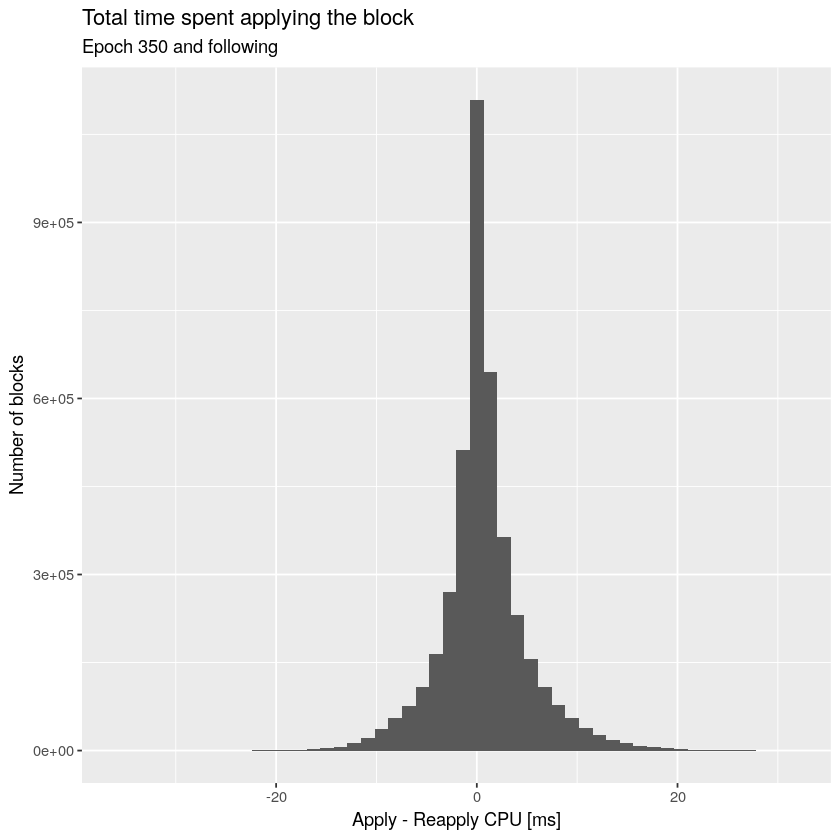

In [17]:
ggplot(data.table(`Actual - Fit [ms]`=residuals(model)), aes(`Actual - Fit [ms]`)) +
    geom_histogram(bins=50) +
    xlab("Apply - Reapply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block",
        "Epoch 350 and following"
    )

In [18]:
ggsave("residual-histogram.png", units="in", dpi=150, width=16, height=8)

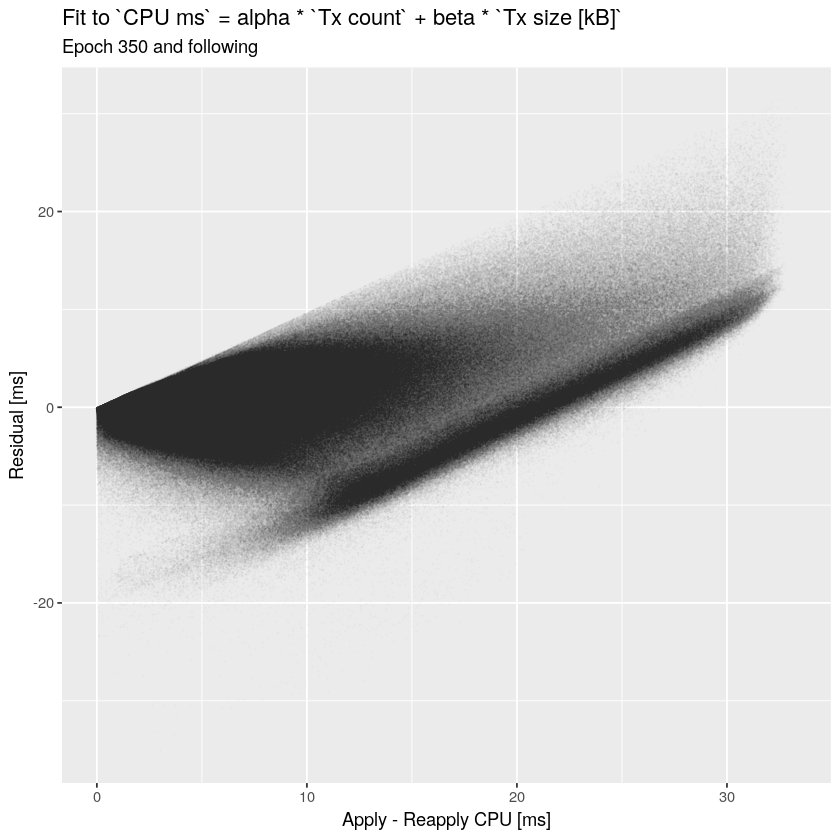

In [19]:
ggplot(
    data.table(
        `Fit [ms]`=model$fitted.values,
        `Actual - Fit [ms]`=residuals(model)
    ), aes(x=`Actual - Fit [ms]`+`Fit [ms]`, y=`Actual - Fit [ms]`)
) +
    geom_point(size=0.025, alpha=0.01) +
    xlab("Apply - Reapply CPU [ms]") +
    ylab("Residual [ms]") +
    ggtitle(
        "Fit to `CPU ms` = alpha * `Tx count` + beta * `Tx size [kB]`",
        "Epoch 350 and following"
    )

In [20]:
ggsave("residual-scatterplot.png", units="in", dpi=150, width=16, height=8)

## Findings

We undertook basic preliminary analysis of block and transaction validation times for Cardano `mainnet` since Epoch 350.

1. The `db-analyser` tool can be used to measure the Cardno block-application time, either including or not including verifying transaction signatures and running Plutus scripts.
2. The output of this tool is quite noisy and does not include enough of the explanatory variable for predicting CPU times for transactions or blocks.
3. The missing explanatory variables (size of UTxO set, number of inputs, number of outputs, etc.) can be extracted from the ledger or `cardano-db-sync`.
4. For transaction signature verification and Plutus script execution, the median times are . . .
    - 0.53 ms/tx
    - 0.29 ms/kB
    - Jointly via a linear model, 0.066 ms/tx plus 0.221 ms/kB.
5. The noise in the data and the uncertainty in predictions make the above values unsuitable for estimating individual transactions but suitable for bulk estimates of many blocks.
6. A more sophisticated double general linear model could be used to generate artificial transaction workloads.